This project explores the use of machine learning models to forecast and detect harmful algal bloom (HAB) conditions. Using real-world environmental data, we train and compare regression models to estimate chlorophyll-a fluorescence — a key indicator of algal concentration — under two problem settings:

1. Real-time detection using environmental features (temperature, sailnity, UVB)
2. Forecasting t+1 using a five-wide rolling window of past chlorophyll levels

We also apply SHAP analysis to interpret the XGBoost forecasting model's decision-making process.

Importing necessary libraries

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Exploring Dataset

In [3]:
df = pd.read_excel("Dataset.xlsx")
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset.xlsx'

Splitting data into train and test datasets

In [26]:
X = df[['Temperature', 'Salinity', 'UVB']]
y = df['ChlorophyllaFlor']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (9858, 3), Test shape: (2465, 3)


Real-Time Chlorophyll Detection

In this section, the goal is to predict chlorophyll levels directly from current environmental indicators (UVB, salinity, temperature), without using past chlorophyll values.

This setting mimics real-time monitoring where lagged biological signals are unavailable. Both Random Forest and XGBoost are tested. 

Continuous Chlorophyll-a Prediction (Detection Setup):
Random Forest → RMSE: 0.1692, R²: 0.8297
XGBoost       → RMSE: 0.1871, R²: 0.7917


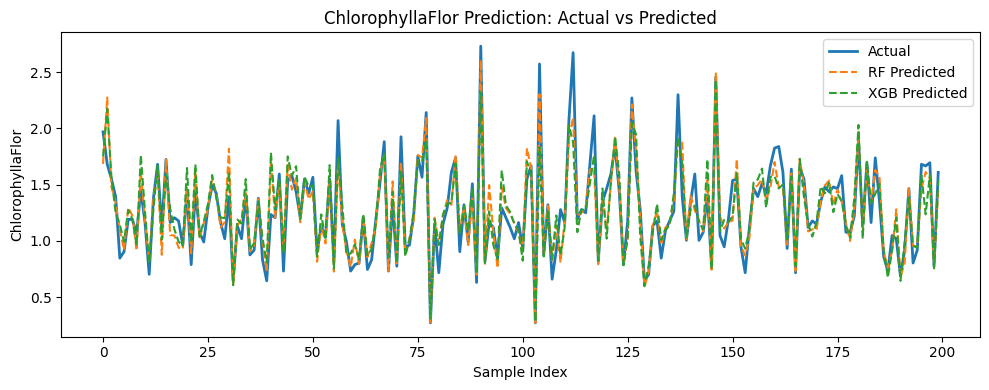

In [27]:
features = ['Temperature', 'Salinity', 'UVB']
X = df[features]
y = df['ChlorophyllaFlor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_pred)

print("Continuous Chlorophyll-a Prediction (Detection Setup):")
print(f"Random Forest → RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
print(f"XGBoost       → RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(rf_pred[:200], label="RF Predicted", linestyle='--')
plt.plot(xgb_pred[:200], label="XGB Predicted", linestyle='--')
plt.title("ChlorophyllaFlor Prediction: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("ChlorophyllaFlor")
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest tuning
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
rf_tuned_pred = best_rf.predict(X_test)
rf_tuned_rmse = np.sqrt(mean_squared_error(y_test, rf_tuned_pred)
rf_tuned_r2 = r2_score(y_test, rf_tuned_pred)

# XGBoost tuning
xgb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    xgb_params,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
xgb_tuned_pred = best_xgb.predict(X_test)
xgb_tuned_rmse = np.sqrt(mean_squared_error(y_test, xgb_tuned_pred))
xgb_tuned_r2 = r2_score(y_test, xgb_tuned_pred)

print("🌿 Tuned Real-Time Detection Results:")
print(f"Random Forest → RMSE: {rf_tuned_rmse:.4f}, R²: {rf_tuned_r2:.4f}")
print(f"XGBoost       → RMSE: {xgb_tuned_rmse:.4f}, R²: {xgb_tuned_r2:.4f}")

SyntaxError: invalid syntax (1002327707.py, line 24)

In order to make a forecasting system, it is necessary to verify if the data is chronologically organized. However, the datasets do not include any explicit time or date information. So, we instead analyze the trends in the data to infer temporal structure. By plotting the chlorophyll-a values sequentially (in row order), we observe smooth, gradual fluctuations that resemble time-series dynamics. This suggests that the dataset is likely ordered chronologically, even if timestamps are missing. Based on this assumption, we proceed to implement rolling window forecasting models, using past chlorophyll values to predict the next step.

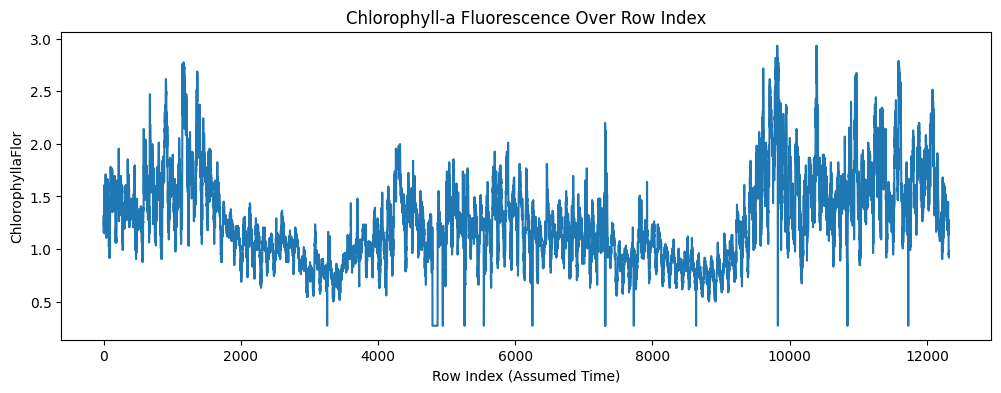

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df['ChlorophyllaFlor'].values)
plt.title("Chlorophyll-a Fluorescence Over Row Index")
plt.xlabel("Row Index (Assumed Time)")
plt.ylabel("ChlorophyllaFlor")
plt.show()

To simulate early-warning systems, we construct a one-step-ahead time series forecasting model for chlorophyll-a using a rolling window of prior values. The input features are lagged chlorophyll levels at times t−5 through t−1, and the target is chlorophyll at time t.

We compare:
- Random Forest Regressor
- XGBoost Regressor

Performance is evaluated using RMSE and R² on a held-out test set.

In [29]:
df_lagged = df.copy()

df_lagged['UVB_lag1'] = df_lagged['UVB'].shift(1)
df_lagged['Salinity_lag1'] = df_lagged['Salinity'].shift(1)
df_lagged['Temperature_lag1'] = df_lagged['Temperature'].shift(1)

df_lagged['ChlorophyllaFlor_next'] = df_lagged['ChlorophyllaFlor'].shift(-1)

df_lagged = df_lagged.dropna()

df_lagged.head()


,Temperature,Salinity,UVB,ChlorophyllaFlor,UVB_lag1,Salinity_lag1,Temperature_lag1,ChlorophyllaFlor_next
1,8.3752,33.926,23.489940,1.248928,28.523490,33.838,8.1743,1.248928
2,8.3399,33.786,18.288590,1.248928,23.489940,33.926,8.3752,1.320908
3,8.3046,33.936,13.758390,1.320908,18.288590,33.786,8.3399,1.248928
4,8.2795,33.863,9.731544,1.248928,13.758390,33.936,8.3046,1.220136
5,8.1095,33.852,6.040269,1.220136,9.731544,33.863,8.2795,1.263324


t+1 Forecast Accuracy (Rolling Window, window_size = 5):
Random Forest → RMSE: 0.1485, R²: 0.8260
XGBoost       → RMSE: 0.1473, R²: 0.8289


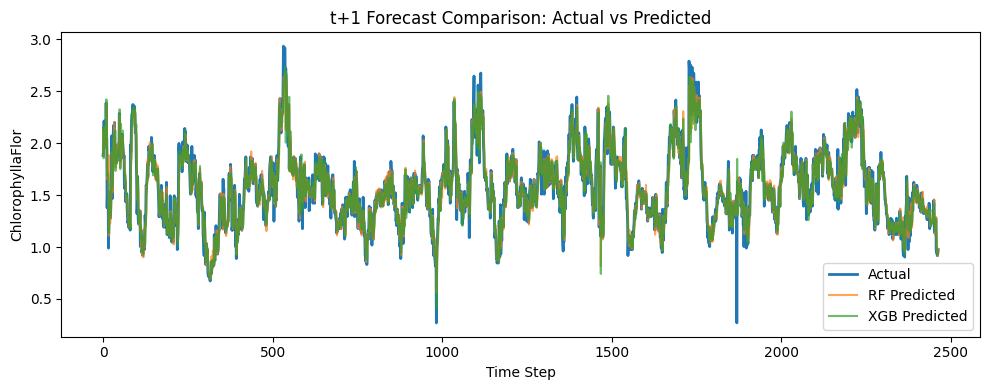

In [30]:
def create_rolling_window_data(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

chl_series = df['ChlorophyllaFlor'].values
window_size = 5
X_roll, y_roll = create_rolling_window_data(chl_series, window_size)

split_idx = int(0.8 * len(X_roll))
X_train, X_test = X_roll[:split_idx], X_roll[split_idx:]
y_train, y_test = y_roll[:split_idx], y_roll[split_idx:]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_rf_pred)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("t+1 Forecast Accuracy (Rolling Window, window_size = 5):")
print(f"Random Forest → RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
print(f"XGBoost       → RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(y_rf_pred, label="RF Predicted", alpha=0.7)
plt.plot(y_xgb_pred, label="XGB Predicted", alpha=0.7)
plt.legend()
plt.title("t+1 Forecast Comparison: Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("ChlorophyllaFlor")
plt.tight_layout()
plt.show()


To interpret the XGBoost forecasting model, we use SHAP (SHapley Additive exPlanations) to measure the contribution of each lagged feature to each prediction. SHAP values provide a global and local explanation of the model's decision-making process, highlighting the importance of short-term chlorophyll trends.

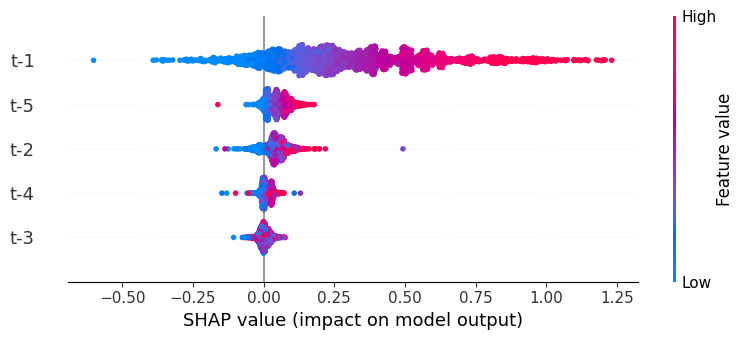

In [31]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=[f't-{i}' for i in range(X_test.shape[1], 0, -1)])

This project explores two machine learning approaches to modeling harmful algal bloom conditions:

- **t+1 Forecasting:** We built a rolling window model using past chlorophyll-a levels to forecast the next time step. XGBoost provided strong performance and interpretability via SHAP analysis.
- **Real-time Detection:** We trained models to detect current chlorophyll levels from environmental features (UVB, temperature, salinity), simulating a sensor-based detection system.

XGBoost and Random Forest both performed well, but XGBoost was slightly more accurate and allowed deeper interpretability. While multi-step forecasting was attempted, it suffered from recursive error accumulation and was ultimately dropped in favor of single-step prediction.

This model provides a strong foundation for early detection or forecasting of harmful algal blooms, with future improvements possible via more granular temporal data or sequence-based models like LSTMs.